In [1]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nv

In [2]:
!pip install shap
!pip install lime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=d830bb2978ac980675f70f24e910b2d882b6d312a62976ef700c152a95daab69
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [3]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
import datetime
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc as sklearn_auc
import lime
import lime.lime_text
import shap
from torchviz import make_dot

# Setup logging
logging.basicConfig(filename='model_training.log', level=logging.INFO)


Mounted at /content/drive


In [4]:

# Preprocessing and Tokenization
def preprocess_data(data):
    data['text'] = data['text'].apply(lambda x: x.lower())
    data['text'] = data['text'].str.replace('[^a-zA-Z\s]', '', regex=True)
    data['text'] = data['text'].str.replace(r'\s+', ' ', regex=True)
    return data

def tokenize_reviews(tokenizer, texts):
    return tokenizer(texts.tolist(), truncation=True, padding=True, max_length=128, return_tensors='pt')


In [5]:

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }


In [6]:

# Regularization
def apply_regularization(model):
    for param in model.parameters():
        param.requires_grad = True
    return model


In [7]:

# Training function
def train_model(model, train_loader, optimizer, scheduler, criterion, num_epochs, device):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")


In [8]:

# Evaluation function
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred_prob = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].cpu().numpy()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()

            y_true.extend(labels)
            y_pred_prob.extend(predictions)

    return np.array(y_true), np.array(y_pred_prob)




In [9]:
# Evaluation Metrics
def log_metrics(metrics):
    logging.info(metrics)

def print_metrics(y_true, y_pred_prob):
    if len(np.unique(y_true)) < 2:
        print("Only one class present in y_true. Skipping metrics calculation for this fold.")
        return

    accuracy = accuracy_score(y_true, y_pred_prob)
    precision = precision_score(y_true, y_pred_prob, zero_division=1)
    recall = recall_score(y_true, y_pred_prob, zero_division=1)
    f1 = f1_score(y_true, y_pred_prob, zero_division=1)
    auc_score = roc_auc_score(y_true, y_pred_prob)

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc_score
    }
    log_metrics(metrics)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"AUC: {auc_score}")

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_auc = sklearn_auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Plot confusion matrix
    plot_confusion_matrix(confusion_matrix(y_true, y_pred_prob))

def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(np.arange(2), ['Negative', 'Positive'])
    plt.yticks(np.arange(2), ['Negative', 'Positive'])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment='center', color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black')
    plt.show()


In [10]:
# Explainability
def explain_with_lime(model, tokenizer, X_test, num_samples=5):
    explainer = lime.lime_text.LimeTextExplainer(class_names=['negative', 'positive'])
    for i in range(num_samples):
        exp = explainer.explain_instance(X_test.iloc[i], lambda x: model(tokenizer(x, return_tensors='pt').to(device)).logits.cpu().detach().numpy(), num_features=10)
        exp.show_in_notebook()

def explain_with_shap(model, tokenizer, X_test, num_samples=5):
    explainer = shap.Explainer(lambda x: model(tokenizer(x, return_tensors='pt').to(device)).logits.cpu().detach().numpy())
    shap_values = explainer(X_test.iloc[:num_samples])
    shap.summary_plot(shap_values, X_test.iloc[:num_samples])


In [11]:

# Robustness and Reliability
def adversarial_testing(model, tokenizer, X_test, y_test, epsilon=0.1):
    adv_X_test = X_test.apply(lambda x: x + epsilon * ''.join(np.random.choice(list('abcdefghijklmnopqrstuvwxyz '), len(x))), axis=1)
    adv_encodings = tokenize_reviews(tokenizer, adv_X_test)
    adv_dataset = CustomDataset(
        adv_encodings['input_ids'],
        adv_encodings['attention_mask'],
        torch.tensor(y_test.values, dtype=torch.long)
    )
    adv_loader = DataLoader(adv_dataset, batch_size=32)
    y_true, y_pred_prob = evaluate_model(model, adv_loader, device)
    print("Adversarial Testing Results:")
    print_metrics(y_true, y_pred_prob)



In [12]:
# Model Saving and Loading
def save_model(model, model_name='bert_model.pth'):
    torch.save(model.state_dict(), model_name)
    print(f"Model saved to {model_name}")

def load_model(model_class, model_name='bert_model.pth'):
    model = model_class.from_pretrained('bert-base-uncased')
    model.load_state_dict(torch.load(model_name))
    return model



In [13]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [14]:
# Load and preprocess data
df = pd.read_csv('/content/drive/MyDrive/Training_Essay_Data00.csv', encoding='latin1')
df = preprocess_data(df)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# Prepare data for cross-validation
X = df['text']
y = df['generated']



In [16]:
# Standalone training and evaluation
def standalone_training_and_evaluation(X, y, tokenizer, model, num_epochs=10):
    # Split the data into train and test sets
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Tokenize the data
    train_encodings = tokenize_reviews(tokenizer, X_train)
    test_encodings = tokenize_reviews(tokenizer, X_test)

    # Create Datasets
    train_dataset = CustomDataset(
        train_encodings['input_ids'],
        train_encodings['attention_mask'],
        torch.tensor(y_train.values, dtype=torch.long)
    )
    test_dataset = CustomDataset(
        test_encodings['input_ids'],
        test_encodings['attention_mask'],
        torch.tensor(y_test.values, dtype=torch.long)
    )

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Define optimizer and scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    total_steps = len(train_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    criterion = torch.nn.CrossEntropyLoss()

    # Train the model
    train_model(model, train_loader, optimizer, scheduler, criterion, num_epochs, device)

    # Evaluate the model
    y_true, y_pred_prob = evaluate_model(model, test_loader, device)
    print("Standalone Training and Evaluation Results:")
    print_metrics(y_true, y_pred_prob)

    # Save the model
    save_model(model, 'standalone_bert_model.pth')



Epoch 1/10, Loss: 0.0693
Epoch 2/10, Loss: 0.0113
Epoch 3/10, Loss: 0.0048
Epoch 4/10, Loss: 0.0018
Epoch 5/10, Loss: 0.0033
Epoch 6/10, Loss: 0.0001
Epoch 7/10, Loss: 0.0000
Epoch 8/10, Loss: 0.0001
Epoch 9/10, Loss: 0.0000
Epoch 10/10, Loss: 0.0000
Standalone Training and Evaluation Results:
Accuracy: 0.9920116194625999
Precision: 0.97900390625
Recall: 0.9995014955134596
F1 Score: 0.989146521953626
AUC: 0.9936113988132689


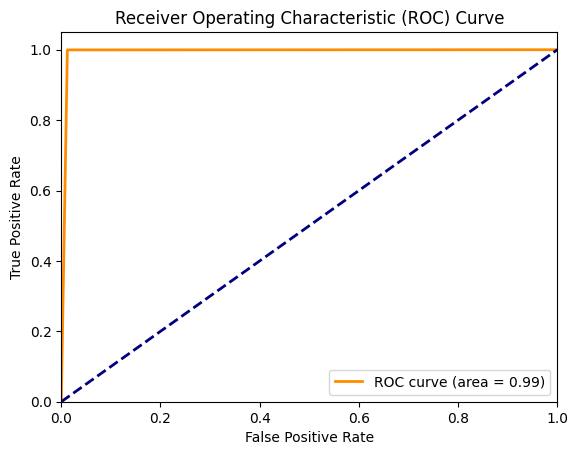

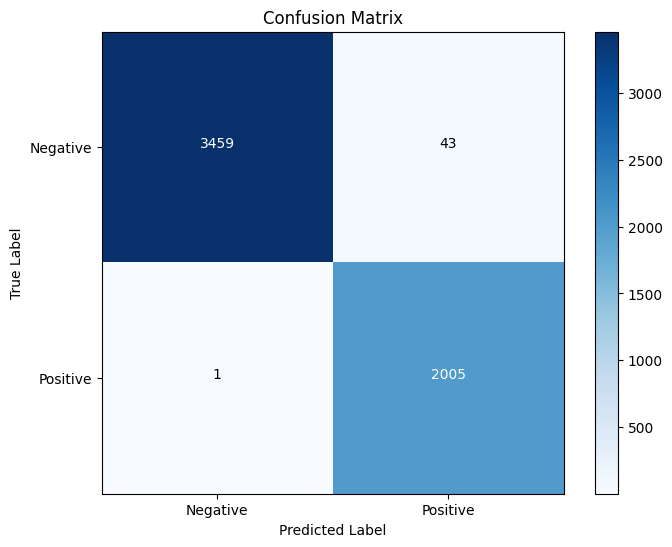

Model saved to standalone_bert_model.pth


In [17]:
standalone_training_and_evaluation(X, y, tokenizer, model)



In [18]:
# Cross-validation
def cross_validation_training(X, y, tokenizer, model_class, n_splits=5, num_epochs=10):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold = 1

    for train_index, test_index in kf.split(X):
        print(f"Training fold {fold}...")

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Tokenize the data
        train_encodings = tokenize_reviews(tokenizer, X_train)
        test_encodings = tokenize_reviews(tokenizer, X_test)

        # Create Datasets
        train_dataset = CustomDataset(
            train_encodings['input_ids'],
            train_encodings['attention_mask'],
            torch.tensor(y_train.values, dtype=torch.long)
        )
        test_dataset = CustomDataset(
            test_encodings['input_ids'],
            test_encodings['attention_mask'],
            torch.tensor(y_test.values, dtype=torch.long)
        )

        # Create DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=32)

        # Define model, optimizer, and scheduler
        model = model_class.from_pretrained('bert-base-uncased', num_labels=2)
        model = apply_regularization(model).to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
        total_steps = len(train_loader) * num_epochs
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
        criterion = torch.nn.CrossEntropyLoss()

        # Train the model
        train_model(model, train_loader, optimizer, scheduler, criterion, num_epochs, device)

        # Evaluate the model
        y_true, y_pred_prob = evaluate_model(model, test_loader, device)
        print(f"Results for fold {fold}:")
        print_metrics(y_true, y_pred_prob)

        fold += 1

        # Save the model
        save_model(model, f'bert_model_fold_{fold}.pth')



Training fold 1...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Loss: 0.0778
Epoch 2/10, Loss: 0.0127
Epoch 3/10, Loss: 0.0049
Epoch 4/10, Loss: 0.0042
Epoch 5/10, Loss: 0.0031
Epoch 6/10, Loss: 0.0004
Epoch 7/10, Loss: 0.0001
Epoch 8/10, Loss: 0.0000
Epoch 9/10, Loss: 0.0000
Epoch 10/10, Loss: 0.0000
Results for fold 1:
Accuracy: 0.9920116194625999
Precision: 0.9785365853658536
Recall: 1.0
F1 Score: 0.9891518737672583
AUC: 0.9937178754997145


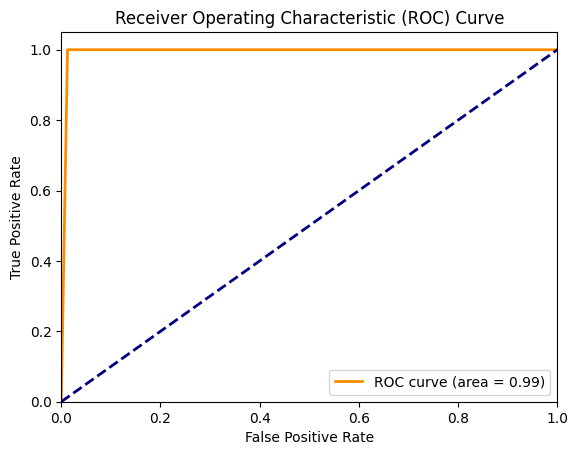

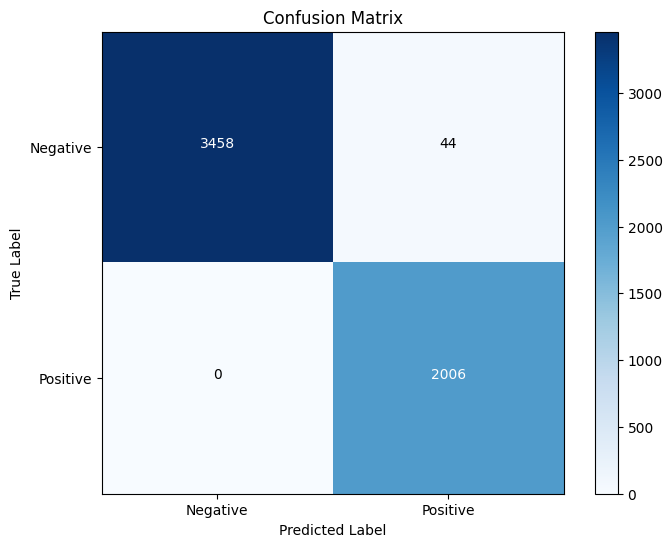

Model saved to bert_model_fold_2.pth
Training fold 2...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Loss: 0.0654
Epoch 2/10, Loss: 0.0126
Epoch 3/10, Loss: 0.0072
Epoch 4/10, Loss: 0.0023
Epoch 5/10, Loss: 0.0021
Epoch 6/10, Loss: 0.0006
Epoch 7/10, Loss: 0.0011
Epoch 8/10, Loss: 0.0001
Epoch 9/10, Loss: 0.0000
Epoch 10/10, Loss: 0.0000
Results for fold 2:
Accuracy: 0.9943718228031954
Precision: 0.98691226369365
Recall: 0.9980392156862745
F1 Score: 0.9924445527662686
AUC: 0.9951268742791235


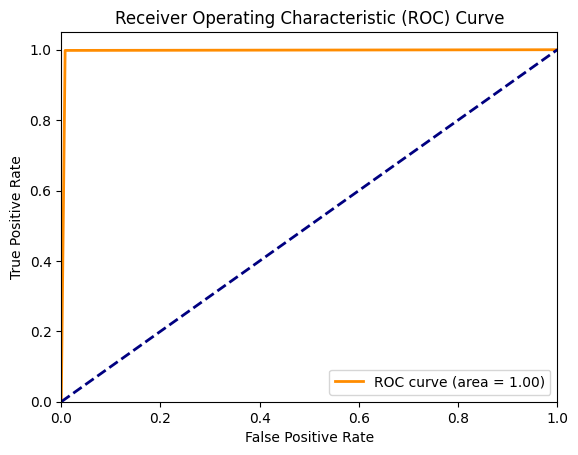

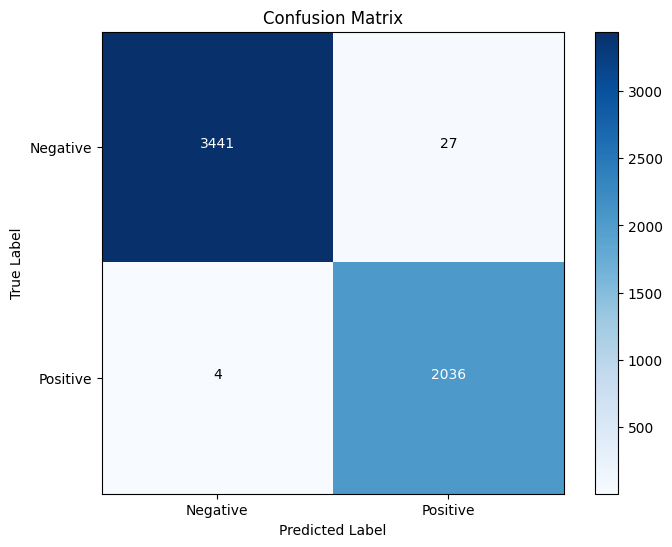

Model saved to bert_model_fold_3.pth
Training fold 3...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Loss: 0.0715
Epoch 2/10, Loss: 0.0151
Epoch 3/10, Loss: 0.0064
Epoch 4/10, Loss: 0.0048
Epoch 5/10, Loss: 0.0009
Epoch 6/10, Loss: 0.0020


In [ ]:
cross_validation_training(X, y, tokenizer, BertForSequenceClassification)
